<a href="https://colab.research.google.com/github/yuzhi535/resnet-pytorch/blob/master/PL_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 安装依赖

In [79]:
%pip install pytorch-lightning torchmetrics einops albumentations timm einops

Looking in indexes: https://mirrors.bfsu.edu.cn/pypi/web/simple
Note: you may need to restart the kernel to use updated packages.


# 定义网络

In [82]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from timm.models.layers import trunc_normal_
from einops.layers.torch import Rearrange


# 基本块
class Conv(nn.Module):
    def __init__(self, in_chan, out_chan, stride) -> None:
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_chan, out_chan, 3, stride, 1, bias=False),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.conv(x)


class BasicLayerX2(nn.Module):
    def __init__(self, in_chan, stride, down_sample: bool) -> None:
        super().__init__()
        out_chan = in_chan
        in_chan = in_chan // 2 if down_sample else in_chan

        # print(f'in_chan={in_chan}, out_chan={out_chan}')

        self.conv = nn.Sequential(
            Conv(in_chan, out_chan, stride),
            Conv(out_chan, out_chan, 1),
        )

        self.shortcut = None
        self.act = nn.ReLU()

        if down_sample:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_chan, out_chan, 1, stride, bias=False),
                nn.BatchNorm2d(out_chan),
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        conv = self.conv(x)
        shortcut = self.shortcut(x)
        return self.act(conv+shortcut)


class BasicLayerX3(nn.Module):
    def __init__(self, in_chan, stride, down_sample: bool) -> None:
        super().__init__()
        out_chan = in_chan
        in_chan = in_chan // 2 if down_sample else in_chan
        self.conv = nn.Sequential(
            Conv(in_chan, out_chan, stride),
            Conv(out_chan, out_chan, stride),
        )

        self.shortcut = None
        self.act = nn.ReLU()

        if down_sample:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_chan, out_chan, 1, stride, bias=False),
                nn.BatchNorm2d(out_chan),
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        return self.act(self.conv(x)+self.shortcut(x))


class Resnet(nn.Module):
    def __init__(self, num_classes, num_layers: list, chan: list) -> None:
        super().__init__()

        # 原论文是先来个7X7卷积，然后下采样，但是考虑数据集为CIFA-10，就稍微改了一下，希望影响不会太大
        self.first_conv = nn.Sequential(
            nn.Conv2d(3, chan[0], 3, 1, 1, bias=False),
            nn.BatchNorm2d(chan[0]),
        )

        self.net = nn.ModuleList()

        for i in range(len(num_layers)):
            # 除了第一层，其他层都是先下采样的block，接着普通block
            self.net += self._make_block(num_layers[i],
                                         chan[i], 2 if i != 0 else 1)

        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            Rearrange('b c h w -> b (c h w)'),
            nn.Linear(chan[-1], num_classes)
        )
        
        

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def _make_block(self, num_layer, chan, stride):
        layer = []
        is_down = False

        strides = [stride] + [1] * (num_layer - 1)

        for stride in strides:
            if stride == 2:
                is_down = True
            layer.append(BasicLayerX2(chan, stride, is_down))
            is_down = False

        return layer

    def forward(self, x):
        out = self.first_conv(x)
        for net in self.net:
            out = net(out)
        out = self.fc(out)

        return out


class Resnet34(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()

        self.net = Resnet(num_classes, [3, 4, 6, 3], [16, 32, 64, 128])

    def forward(self, x):
        return self.net(x)


if __name__ == '__main__':
    x = torch.randn(2, 3, 32, 32)

    net = Resnet34(10)
    out = net(x)
    print(out.shape)


torch.Size([2, 10])


# 数据准备

In [83]:
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CIFAR10
# import albumentations as A
import numpy as np
from torchvision import transforms

# from sklearn.model_selection import train_test_split


def get_CIFAdataset_loader(root, batch_size, num_workers, pin_memory, valid_rate, shuffle: bool, random_seed=42, augment=True, ):
    # 引入分割CIFA数据集的包，分割数据为训练集和验证集
    from torch.utils.data.sampler import SubsetRandomSampler

    # 预处理
    train_transform = transforms.Compose([
        transforms.Compose([transforms.RandomCrop(32, padding=4),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(), ]) if augment else transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010],
        )
    ]
    )

    val_transform = transforms.Compose([
        transforms.Compose([transforms.RandomCrop(32, padding=4),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(), ]) if augment else transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010],
        )
    ]
    )

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010],
        )
    ]
    )

    # CIFA-10数据集
    train_dataset = CIFAR10(root=root, train=True,
                            download=True, transform=train_transform)
    val_dataset = CIFAR10(root=root, train=True,
                          download=False, transform=val_transform)
    test_dataset = CIFAR10(root=root, train=False,
                           download=True, transform=test_transform)

    # 分割数据集
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_rate * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # 生成dataloader
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = DataLoader(
        val_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    test_loader = DataLoader(
        test_dataset, batch_size=1,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    return train_loader, valid_loader, test_loader


def get_CIFAdataset(root, batch_size, num_workers, pin_memory, valid_rate, shuffle: bool, random_seed=42, augment=True):
    # 引入分割CIFA数据集的包，分割数据为训练集和验证集
    from torch.utils.data.sampler import SubsetRandomSampler


    # CIFA-10数据集
    train_dataset = CIFAR10(root=root, train=True,
                            download=True, transform=None)
    val_dataset = CIFAR10(root=root, train=True,
                          download=False, transform=None)
    test_dataset = CIFAR10(root=root, train=False,
                           download=True, transform=None)
    return train_dataset, val_dataset, test_dataset


# 训练代码

In [84]:
import argparse
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchmetrics
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint


def arg_parser():
    parser = argparse.ArgumentParser()

    parser.add_argument('--batch-size', '-bs', type=int,
                        default=16, required=True, help='input batch size')
    parser.add_argument('--num-workers', '-nw',  type=int,
                        default=4, required=True, help='number of workers')
    # parser.add_argument('--resume', '-r', type=str,
    #                     required=False, help='resume a train')
    parser.add_argument('--device', type=str,
                        help='gpu or cpu', choices=['gpu', 'cpu'], default='gpu')
    parser.add_argument('--num-classes', '-nc', type=int,
                        help='number of classes', required=True)
    parser.add_argument('--lr', '-lr', type=float, default=1e-4)
    parser.add_argument('--epochs', type=int,
                        required=True,  help='num of epochs')

    args = parser.parse_args()
    return args


# 配置训练步骤
class MyResnet(pl.LightningModule):
    def __init__(self, net, num_classes, 
                 lr=1e-4,) -> None:
        super(MyResnet, self).__init__()
        self.net = net
        # self.save_hyperparameters(ignore=['criterion', 'net'])
        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr
        self.acc = torchmetrics.Accuracy(num_classes=num_classes)

        # 损失函数
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.net(x)
    

    def training_step(self, batch, batch_idx):
        x, y,  = batch
        pred = self(x)
        loss = self.criterion(pred, y)
        self.log('loss', loss,
                 logger=True, enable_graph=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, = batch

        pred = self(x)
        self.acc.update(pred, y)
        loss = self.criterion(pred, y)

        return loss

    def validation_epoch_end(self, outputs):
        acc = self.acc.compute()
        self.log('acc', acc, enable_graph=True)
        self.acc.reset()
    
    def test_step(self, batch, batch_idx):
        x, y, = batch

        pred = self(x)
        self.acc.update(pred, y)
        loss = self.criterion(pred, y)
        
        return loss
    
    def test_epoch_end(self, outputs) -> None:
        self.log('eval_acc', self.acc.compute())
        
    def on_test_epoch_start(self) -> None:
        self.acc.reset()



    def configure_optimizers(self):
        opt = torch.optim.Adam(self.net.parameters(),
                               lr=self.lr)
        # sch = torch.optim.lr_scheduler.CosineAnnealingLR(
        # opt, T_max=self.epochs, eta_min=1e-5)
        # sch = torch.optim.lr_scheduler.StepLR(
        # opt, step_size=5, gamma=0.9, last_epoch=-1, verbose=False)
        # return [opt], [sch]
        return opt


def train(net, epochs, bs, nw, lr, num_classes, device):



    # 设置数据集加载，由于CIFA-10本身pytorch自带有，所以这里比较简单
    train_dataloader, val_dataloader, test_dataloader = \
        get_CIFAdataset_loader(
            root='./data/CIFA', batch_size=bs, num_workers=nw, pin_memory=True, valid_rate=0.2, shuffle=True)

    model = MyResnet(net=net,
                     lr=lr, num_classes=num_classes)

    early_stop_callback = EarlyStopping(
        monitor="acc", min_delta=0.0, patience=30, verbose=True, mode="max")

    lr_monitor = LearningRateMonitor(logging_interval='epoch')

    checkpoint_callback = ModelCheckpoint(
        save_top_k=5, monitor='acc', mode='max', filename="{epoch:03d}-{acc:.4f}", verbose=True)

    trainer = pl.Trainer(max_epochs=epochs,
                         log_every_n_steps=10,
                         benchmark=True,
                         check_val_every_n_epoch=1,
                         gradient_clip_val=0.5,
                         devices=1,
                         accelerator=device,
                         callbacks=[
                             checkpoint_callback,
                             lr_monitor,
                             early_stop_callback,
                         ],
    )

    trainer.logger._default_hp_metric = None

    resume_path = None

    trainer.fit(model=model, ckpt_path=resume_path, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

    trainer.test(model=model, dataloaders=test_dataloader)


In [85]:
# args = arg_parser()
bs = 64  # args.batch_size
num_workers = 2  # args.num_workers
device = 'gpu'  # args.device
num_classes = 10  # args.num_classes
lr = 0.001  # args.num_classes
epochs = 10  # args.epochs

pl.seed_everything(42)

net = Resnet34(num_classes)
train(net, epochs, bs, num_workers, lr, num_classes, device=device)

Global seed set to 42


Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | net       | Resnet34         | 1.3 M 
1 | criterion | CrossEntropyLoss | 0     
2 | acc       | Accuracy         | 0     
-----------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.338     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/root/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/root/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric acc improved. New best score: 0.540
Epoch 0, global step 625: 'acc' reached 0.53990 (best 0.53990), saving model to '/root/code/resnet-pytorch/lightning_logs/version_1/checkpoints/epoch=000-acc=0.5399.ckpt' as top 5


Validation: 0it [00:00, ?it/s]

Metric acc improved by 0.070 >= min_delta = 0.0. New best score: 0.610
Epoch 1, global step 1250: 'acc' reached 0.61030 (best 0.61030), saving model to '/root/code/resnet-pytorch/lightning_logs/version_1/checkpoints/epoch=001-acc=0.6103.ckpt' as top 5


Validation: 0it [00:00, ?it/s]

Metric acc improved by 0.074 >= min_delta = 0.0. New best score: 0.684
Epoch 2, global step 1875: 'acc' reached 0.68440 (best 0.68440), saving model to '/root/code/resnet-pytorch/lightning_logs/version_1/checkpoints/epoch=002-acc=0.6844.ckpt' as top 5


Validation: 0it [00:00, ?it/s]

Metric acc improved by 0.025 >= min_delta = 0.0. New best score: 0.710
Epoch 3, global step 2500: 'acc' reached 0.70990 (best 0.70990), saving model to '/root/code/resnet-pytorch/lightning_logs/version_1/checkpoints/epoch=003-acc=0.7099.ckpt' as top 5


Validation: 0it [00:00, ?it/s]

Metric acc improved by 0.013 >= min_delta = 0.0. New best score: 0.723
Epoch 4, global step 3125: 'acc' reached 0.72300 (best 0.72300), saving model to '/root/code/resnet-pytorch/lightning_logs/version_1/checkpoints/epoch=004-acc=0.7230.ckpt' as top 5


Validation: 0it [00:00, ?it/s]

Metric acc improved by 0.068 >= min_delta = 0.0. New best score: 0.791
Epoch 5, global step 3750: 'acc' reached 0.79150 (best 0.79150), saving model to '/root/code/resnet-pytorch/lightning_logs/version_1/checkpoints/epoch=005-acc=0.7915.ckpt' as top 5


Validation: 0it [00:00, ?it/s]

Metric acc improved by 0.003 >= min_delta = 0.0. New best score: 0.795
Epoch 6, global step 4375: 'acc' reached 0.79460 (best 0.79460), saving model to '/root/code/resnet-pytorch/lightning_logs/version_1/checkpoints/epoch=006-acc=0.7946.ckpt' as top 5


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 5000: 'acc' reached 0.77900 (best 0.79460), saving model to '/root/code/resnet-pytorch/lightning_logs/version_1/checkpoints/epoch=007-acc=0.7790.ckpt' as top 5


Validation: 0it [00:00, ?it/s]

Metric acc improved by 0.003 >= min_delta = 0.0. New best score: 0.797
Epoch 8, global step 5625: 'acc' reached 0.79740 (best 0.79740), saving model to '/root/code/resnet-pytorch/lightning_logs/version_1/checkpoints/epoch=008-acc=0.7974.ckpt' as top 5


Validation: 0it [00:00, ?it/s]

Metric acc improved by 0.014 >= min_delta = 0.0. New best score: 0.811
Epoch 9, global step 6250: 'acc' reached 0.81130 (best 0.81130), saving model to '/root/code/resnet-pytorch/lightning_logs/version_1/checkpoints/epoch=009-acc=0.8113.ckpt' as top 5
`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        eval_acc            0.8137000203132629
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


# Resume

In [24]:
def resume(net, resume_path, ):
    net.load_state_dict(torch.load(resume_path,), strict=False)
    return net

net = Resnet34(num_classes=10)
net = resume(net,resume_path='./lightning_logs/version_1/checkpoints/epoch=009-acc=0.8113.ckpt')

    

In [86]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

Model's state_dict:
net.first_conv.0.weight 	 torch.Size([16, 3, 3, 3])
net.first_conv.1.weight 	 torch.Size([16])
net.first_conv.1.bias 	 torch.Size([16])
net.first_conv.1.running_mean 	 torch.Size([16])
net.first_conv.1.running_var 	 torch.Size([16])
net.first_conv.1.num_batches_tracked 	 torch.Size([])
net.net.0.conv.0.conv.0.weight 	 torch.Size([16, 16, 3, 3])
net.net.0.conv.0.conv.1.weight 	 torch.Size([16])
net.net.0.conv.0.conv.1.bias 	 torch.Size([16])
net.net.0.conv.0.conv.1.running_mean 	 torch.Size([16])
net.net.0.conv.0.conv.1.running_var 	 torch.Size([16])
net.net.0.conv.0.conv.1.num_batches_tracked 	 torch.Size([])
net.net.0.conv.1.conv.0.weight 	 torch.Size([16, 16, 3, 3])
net.net.0.conv.1.conv.1.weight 	 torch.Size([16])
net.net.0.conv.1.conv.1.bias 	 torch.Size([16])
net.net.0.conv.1.conv.1.running_mean 	 torch.Size([16])
net.net.0.conv.1.conv.1.running_var 	 torch.Size([16])
net.net.0.conv.1.conv.1.num_batches_tracked 	 torch.Size([])
net.net.1.conv.0.conv.0.weight 	 

# pytorch gradcam

In [87]:
%pip install  grad-cam

Looking in indexes: https://mirrors.bfsu.edu.cn/pypi/web/simple
Note: you may need to restart the kernel to use updated packages.


In [185]:
from PIL import Image
def get_image_from_url(url):
    """A function that gets a URL of an image, 
    and returns a numpy image and a preprocessed
    torch tensor ready to pass to the model """
    import requests
    import cv2
    from pytorch_grad_cam.utils.image import preprocess_image

    
    img = np.array(Image.open(requests.get(url, stream=True).raw))
    img = cv2.resize(img, (512, 512))
    rgb_img_float = np.float32(img) / 255
    input_tensor = preprocess_image(rgb_img_float,
                                   mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
    return img, rgb_img_float, input_tensor

## 原图
这里以猫和人同框为演示。因为cifar10数据集没有人这个类别，但有猫这个类别，因此按理说这里分类会分成猫类。

In [210]:
url = r"https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fp2.itc.cn%2Fq_70%2Fimages03%2F20200617%2F0892032fe1e94e7a975d4c88d46df763.jpeg&refer=http%3A%2F%2Fp2.itc.cn&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=auto?sec=1664795995&t=9198b20affba735164e930300b7a727e"

cat_img, cat_img_float, cat_tensor = get_image_from_url(url)

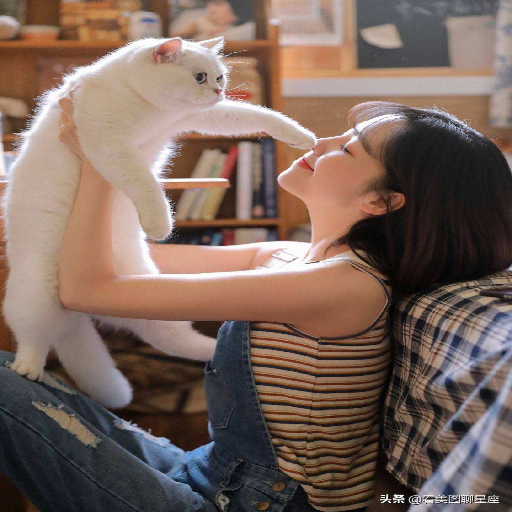

In [211]:
Image.fromarray(cat_img)

## 选择目标层(target layer)

In [168]:
target_layers = [net.net.net[15]]

## 可视化

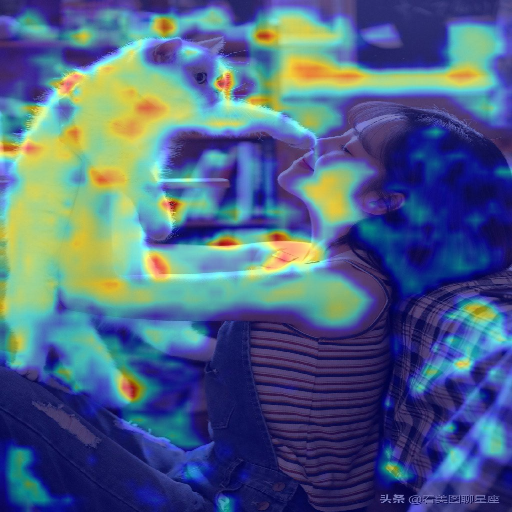

In [212]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from PIL import Image


cam = GradCAM(model=net, target_layers=target_layers, use_cuda=True)

targets = [ClassifierOutputTarget(3)]
data = cat_tensor.to('cuda', torch.float)

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=data, targets=targets)

grayscale_cam = grayscale_cam[0, :]

with GradCAM(model=net,
             target_layers=target_layers,
             use_cuda=True) as cam:
    car_grayscale_cam = cam(input_tensor=data,
                        targets=targets)[0, :]
visualization = show_cam_on_image(cat_img_float, grayscale_cam, use_rgb=True)
Image.fromarray(visualization)


## 检验推理结果
由于猫在cifar10中的数字为3，这里检验正好为3，因此分类成功

In [207]:
cat_tensor.shape
pred = net(cat_tensor.to('cuda'))
pred.argmax()

tensor(3, device='cuda:0')